# Facial Emotions Recognition

Project is in progress

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

tf.config.set_soft_device_placement(True)

### Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils.image_utils import load_img, img_to_array

from os import listdir

### Importing Train and Test sets

In [3]:
listdir("images/train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
emotion_map = {"angry" : 0, "disgust" : 1, "fear" : 2, "happy": 3, "neutral": 4, "sad" : 5, "surprise" : 6}

train_data = {"image" : [], "emotion" : []}


for emotion in listdir("images\\images\\train"):
    emotion_type = emotion_map[emotion]
    emotion_dir = "images\\images\\train\\" + emotion + "\\"
    for image_name in listdir(emotion_dir):
        image_path = emotion_dir + image_name
        train_data["image"].append(image_path)
        train_data["emotion"].append(emotion_type)
        
        
train_df = pd.DataFrame(train_data)

train_df.to_csv("train_df.csv")

train_df.head()

,image,emotion
0,images\images\train\angry\0.jpg,0
1,images\images\train\angry\1.jpg,0
2,images\images\train\angry\10.jpg,0
3,images\images\train\angry\10002.jpg,0
4,images\images\train\angry\10016.jpg,0


In [5]:
test_data = {"image" : [], "emotion" : []}


for emotion in listdir("images\\images\\validation"):
    emotion_type = emotion_map[emotion]
    emotion_dir = "images\\images\\validation\\" + emotion + "\\"
    for image_name in listdir(emotion_dir):
        image_path = emotion_dir + image_name
        test_data["image"].append(image_path)
        test_data["emotion"].append(emotion_type)
        
        
test_df = pd.DataFrame(test_data)

test_df.to_csv("test_df.csv")

test_df.head()

,image,emotion
0,images\images\validation\angry\10052.jpg,0
1,images\images\validation\angry\10065.jpg,0
2,images\images\validation\angry\10079.jpg,0
3,images\images\validation\angry\10095.jpg,0
4,images\images\validation\angry\10121.jpg,0


### EDA

In [6]:
train_df = pd.read_csv("train_df.csv", index_col=0)
test_df = pd.read_csv("test_df.csv", index_col=0)

In [7]:
train_df["emotion"].value_counts()

emotion
3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: count, dtype: int64

In [8]:
test_df["emotion"].value_counts()

emotion
3    1825
4    1216
5    1139
2    1018
0     960
6     797
1     111
Name: count, dtype: int64

In [9]:
train_df["emotion"].value_counts()  

emotion
3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: count, dtype: int64

### Preprocessing

In [10]:
train_df["image_array"] = train_df["image"].apply(lambda x : img_to_array(load_img(x)))
train_df["image_array"]

0        [[[72.0, 72.0, 72.0], [78.0, 78.0, 78.0], [81....
1        [[[152.0, 152.0, 152.0], [149.0, 149.0, 149.0]...
2        [[[29.0, 29.0, 29.0], [25.0, 25.0, 25.0], [21....
3        [[[32.0, 32.0, 32.0], [23.0, 23.0, 23.0], [20....
4        [[[222.0, 222.0, 222.0], [218.0, 218.0, 218.0]...
                               ...                        
28816    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
28817    [[[130.0, 130.0, 130.0], [134.0, 134.0, 134.0]...
28818    [[[243.0, 243.0, 243.0], [220.0, 220.0, 220.0]...
28819    [[[253.0, 253.0, 253.0], [252.0, 252.0, 252.0]...
28820    [[[213.0, 213.0, 213.0], [218.0, 218.0, 218.0]...
Name: image_array, Length: 28821, dtype: object

In [11]:
test_df["image_array"] = test_df["image"].apply(lambda x : img_to_array(load_img(x)))
test_df["image_array"]

0       [[[58.0, 58.0, 58.0], [66.0, 66.0, 66.0], [70....
1       [[[23.0, 23.0, 23.0], [26.0, 26.0, 26.0], [21....
2       [[[201.0, 201.0, 201.0], [182.0, 182.0, 182.0]...
3       [[[93.0, 93.0, 93.0], [86.0, 86.0, 86.0], [78....
4       [[[11.0, 11.0, 11.0], [6.0, 6.0, 6.0], [1.0, 1...
                              ...                        
7061    [[[255.0, 255.0, 255.0], [253.0, 253.0, 253.0]...
7062    [[[84.0, 84.0, 84.0], [71.0, 71.0, 71.0], [70....
7063    [[[250.0, 250.0, 250.0], [253.0, 253.0, 253.0]...
7064    [[[228.0, 228.0, 228.0], [224.0, 224.0, 224.0]...
7065    [[[78.0, 78.0, 78.0], [116.0, 116.0, 116.0], [...
Name: image_array, Length: 7066, dtype: object

### Image Augumentation

In this project I've decided to use image augumentation in order to solve 2 problems:
1. Small amount of train data
2. Class disbalance

To solve class disbalance, we need to check class balance in train set

In [12]:
train_df["emotion"].value_counts() / train_df.shape[0]

emotion
3    0.248569
4    0.172860
5    0.171333
2    0.142361
0    0.138545
6    0.111204
1    0.015128
Name: count, dtype: float64

I want to augment the training dataset so that I have 10000 images of each emotion. Before applying image augmentation, I need to know how many times I need to apply it to solve the class imbalance problem. So, let's calculate this. I will round the calculated value so that they are natural numbers, and after applying it, I will remove some extra examples to have the same number of exemplars of each class

In [13]:
from math import ceil

(10000 / train_df["emotion"].value_counts()).apply(lambda x : ceil(x))

emotion
3     2
4     3
5     3
2     3
0     3
6     4
1    23
Name: count, dtype: int64

In [14]:
train_df["emotion"] = train_df["emotion"].astype(int)

In [21]:
from keras.preprocessing.image import ImageDataGenerator


augumentaion_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

def augumentation(image, generator):
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image_augumented = generator.flow(image).next()[0]
    return image_augumented


class_ratios = (20000 / train_df["emotion"].value_counts()).apply(lambda x : ceil(x))

emotion_map = dict()

for emotion in range(0, 7):
    emotion_map[emotion] = train_df[train_df["emotion"] == emotion]


augumented_emotion_map = dict()

for emotion in range(0, 7):
    augumented_images = pd.DataFrame()
    for _ in range(class_ratios[emotion]):
        temp = emotion_map[emotion].copy()
        temp["image_array"] = temp["image_array"].apply(lambda x : augumentation(x, augumentaion_generator))
        augumented_images = pd.concat([augumented_images, temp], axis="rows")
    
    augumented_emotion_map[emotion] = augumented_images
        


In [22]:
augumented_train = pd.DataFrame()

for emotion in range(0, 7):
    augumented_train = pd.concat([augumented_train, augumented_emotion_map[emotion].sample(20000)], axis="rows")
    
augumented_train["emotion"].value_counts()
    

emotion
0    20000
1    20000
2    20000
3    20000
4    20000
5    20000
6    20000
Name: count, dtype: int64

### Building NN Architecture

In [23]:
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPool2D, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.resnet import ResNet101
from keras.regularizers import l2

model = Sequential()

#Input 
model.add(Input(shape=(48, 48, 3)))

model.add(Conv2D(filters=64, kernel_size=(2, 2)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Activation("relu"))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=128, kernel_size=(2, 2)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Activation("relu"))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=256, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Activation("relu"))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=512, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Activation("relu"))
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))


model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(7, activation="softmax"))

model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 activation_4 (Activation)   (None, 23, 23, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)      

### Model Training

Epoch 1/100
4375/4375 [==============================] - 102s 22ms/step - loss: 1.7601 - accuracy: 0.3004 - val_loss: 1.6216 - val_accuracy: 0.4007 - lr: 1.0000e-04
Epoch 2/100
4375/4375 [==============================] - 88s 20ms/step - loss: 1.4703 - accuracy: 0.4392 - val_loss: 1.4475 - val_accuracy: 0.4581 - lr: 1.0000e-04
Epoch 3/100
4375/4375 [==============================] - 82s 19ms/step - loss: 1.3380 - accuracy: 0.4943 - val_loss: 1.1836 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 4/100
4375/4375 [==============================] - 84s 19ms/step - loss: 1.2536 - accuracy: 0.5251 - val_loss: 1.2185 - val_accuracy: 0.5405 - lr: 1.0000e-04
Epoch 5/100
4375/4375 [==============================] - 84s 19ms/step - loss: 1.1896 - accuracy: 0.5522 - val_loss: 1.1213 - val_accuracy: 0.5767 - lr: 1.0000e-04
Epoch 6/100
4375/4375 [==============================] - 83s 19ms/step - loss: 1.1351 - accuracy: 0.5719 - val_loss: 1.1226 - val_accuracy: 0.5740 - lr: 1.0000e-04
Epoch 7/100
437

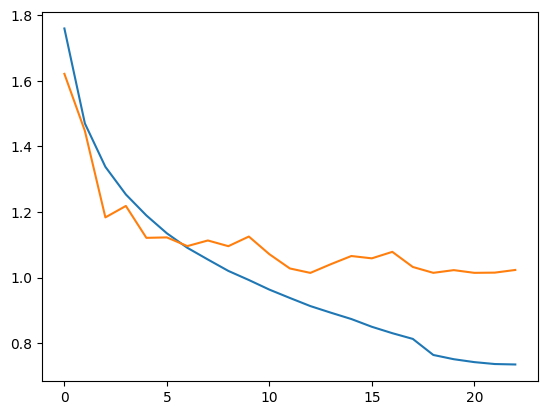

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)

train_images = np.stack(augumented_train["image_array"].values)
train_labels = augumented_train["emotion"].values

test_images = np.stack(test_df["image_array"].values)
test_labels = test_df["emotion"].values

train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.1)

hitsory = model.fit(train_generator.flow(train_images, train_labels, batch_size=32),
          validation_data=test_generator.flow(test_images, test_labels, batch_size=32),
          epochs=100, callbacks=[early_stopping, reduce_lr])

temp = pd.DataFrame(hitsory.history).reset_index()

plt.plot(temp["index"], temp["loss"])
plt.plot(temp["index"], temp["val_loss"])


In [34]:
from keras.models import save_model

save_model(model, "model0_64va.h5")

## Merging with OpenCV and Results

#### Model import and prediction parses

In [35]:
from keras.models import save_model, load_model
import numpy as np

model = load_model("model0_64va.h5")

def parce_predictions(x : np.array):
    emotion_map_reversed = {0 : "angry", 1 : "disgust" , 2 : "fear" , 3 : "happy", 4 : "neutral", 5 : "sad" , 6 : "surprise"}
    emotion = x.argmax()
    return emotion_map_reversed[emotion]

#### Important Defininitions

In [36]:
import cv2
import sys
from keras.utils.image_utils import array_to_img, img_to_array
import numpy as np

cascPath = "haarcascade_frontalface_default.xml"
temp = None
crop = None

window_name = 'Image'
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (50, 50) 
fontScale = 1
color = (255, 0, 0) 
thickness = 2


faceCascade = cv2.CascadeClassifier(cascPath)
video_capture = cv2.VideoCapture(0)

while True:
    
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    text = None
 
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        crop = (x, w, y, h)
        face_image = gray[y:y+h, x:x+w]

        face_image = face_image[..., np.newaxis]

        image = img_to_array(array_to_img(face_image).resize((48, 48)))
        image = np.repeat(image, 3, axis=2)

        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	
        text = parce_predictions(model.predict(image, verbose=0))
    
    frame = cv2.putText(frame, text, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    cv2.imshow('Video', frame)
    temp = frame

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

### Summary

In that version of project I've achieved 64 validation accuracy